In [1]:
import os
import numpy as np

from PIL import Image
import matplotlib.pyplot as plt

import torch
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms

import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import CosineAnnealingLR
from torchvision.transforms import functional as F
import torchvision.transforms as T

import random

from tqdm import tqdm

In [2]:
SEED = 1834579291

np.random.seed(SEED)
random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed(SEED)
    torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [3]:
class Conf:
    train_dir = '/kaggle/input/imagenet-object-localization-challenge/ILSVRC/Data/CLS-LOC/train'
    val_dir = '/kaggle/input/imagenet-object-localization-challenge/ILSVRC/Data/CLS-LOC/val'
    test_dir = '/kaggle/input/imagenet-object-localization-challenge/ILSVRC/Data/CLS-LOC/test'

    batch_size = 16

    scaling_factor = 4
    x_patch_size = 24
    y_patch_size = scaling_factor * x_patch_size
    
    subset_size = 30000

In [4]:
class ImageDataset(Dataset):
    def __init__(self, image_dir, x_patch_size, y_patch_size, train_set=False):
        self.image_dir = image_dir
        self.x_patch_size = x_patch_size
        self.y_patch_size = y_patch_size
        self.train_set = train_set

        self.to_tensor = T.ToTensor()
        
        if self.train_set:
            subdirs = [os.path.join(image_dir, d) for d in os.listdir(image_dir) 
                       if os.path.isdir(os.path.join(image_dir, d))]

            self.image_paths = []
            for d in subdirs:
                for fname in os.listdir(d):
                    if fname.lower().endswith(('.png', '.jpg', '.jpeg')):
                        self.image_paths.append(os.path.join(d, fname))
        else:
            self.image_paths = [os.path.join(image_dir, fname) for fname in os.listdir(image_dir)
                                if fname.lower().endswith(('.png', '.jpg', '.jpeg'))]

        # if self.train_set:
        self.image_paths = self.image_paths[:Conf.subset_size]

        self.image_paths.sort()

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert('RGB')
        w, h = image.size

        if (w < self.y_patch_size or h < self.y_patch_size):
            image = image.resize((self.y_patch_size, self.y_patch_size), Image.BICUBIC)
            w, h = image.size

        if self.train_set:
            x1 = random.randint(0, w - self.y_patch_size)
            y1 = random.randint(0, h - self.y_patch_size)
        else:
            x1 = (w - self.y_patch_size) // 2
            y1 = (h - self.y_patch_size) // 2

        y_patch = image.crop((x1, y1, x1 + self.y_patch_size, y1 + self.y_patch_size))
        x_patch = y_patch.resize((self.x_patch_size, self.x_patch_size), Image.BICUBIC)

        x_tensor = self.to_tensor(x_patch)
        y_tensor = self.to_tensor(y_patch)

        y_tensor = y_tensor * 2.0 - 1.0
        
        return x_tensor, y_tensor        

In [5]:
%%time

train_dataset = ImageDataset(Conf.train_dir, Conf.x_patch_size, Conf.y_patch_size, True)
val_dataset = ImageDataset(Conf.val_dir, Conf.x_patch_size, Conf.y_patch_size)
test_dataset = ImageDataset(Conf.val_dir, Conf.x_patch_size, Conf.y_patch_size)

train_loader = DataLoader(train_dataset, batch_size = Conf.batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size = Conf.batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size = Conf.batch_size, shuffle=False)

CPU times: user 2.06 s, sys: 815 ms, total: 2.87 s
Wall time: 16.3 s


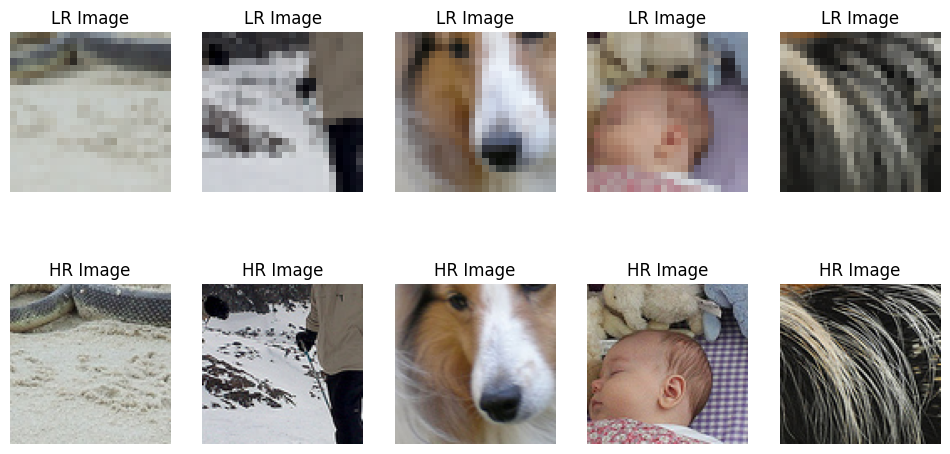

In [6]:
def display_samples(loader, num_samples=5):
    samples_displayed = 0
    plt.figure(figsize=(12, 6))
    for x, y in loader:
        for i in range(x.size(0)):
            if samples_displayed >= num_samples:
                plt.show()
                return
            
            plt.subplot(2, num_samples, samples_displayed + 1)
            plt.imshow(x[i].permute(1, 2, 0).numpy())
            plt.title("LR Image")
            plt.axis('off')

            plt.subplot(2, num_samples, samples_displayed + 1 + num_samples)
            plt.imshow(((y + 1) / 2.0)[i].permute(1, 2, 0).numpy(), cmap='gray')
            plt.title("HR Image")
            plt.axis('off')
            
            samples_displayed += 1

display_samples(test_loader)

In [7]:
class ResidualBlock(nn.Module):
    def __init__(self, channels):
        super(ResidualBlock, self).__init__()
        self.block = nn.Sequential(
            nn.Conv2d(channels, channels, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(channels, channels, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(channels)
        )
    
    def forward(self, x):
        return x + self.block(x)

class SRResNet(nn.Module):
    def __init__(self, num_channels=3, num_blocks=16, upscale_factor=4):
        super(SRResNet, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(num_channels, 64, kernel_size=9, stride=1, padding=4),
            nn.ReLU(inplace=True)
        )

        self.res_blocks = nn.Sequential(
            *[ResidualBlock(64) for _ in range(num_blocks)]
        )

        self.conv2 = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64)
        )

        self.upscale = nn.Sequential(
            nn.Conv2d(64, 64 * upscale_factor, kernel_size=3, stride=1, padding=1),
            nn.PixelShuffle(int(np.sqrt(upscale_factor))),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64 * upscale_factor, kernel_size=3, stride=1, padding=1),
            nn.PixelShuffle(int(np.sqrt(upscale_factor))),
            nn.ReLU(inplace=True),
        )

        self.conv3 = nn.Sequential(
            nn.Conv2d(64, num_channels, kernel_size=9, stride=1, padding=4),
            nn.Tanh()
        )

    def forward(self, x):
        x = self.conv1(x)
        residual = self.res_blocks(x)
        x = self.conv2(residual) + x
        x = self.upscale(x)
        x = self.conv3(x)
        return x

In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = SRResNet(num_channels=3, num_blocks=16, upscale_factor=Conf.scaling_factor).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)
scheduler = CosineAnnealingLR(optimizer, T_max=50, eta_min=1e-7)

In [9]:
def train_model(model, dataloader, criterion, optimizer, device):
    model.train()
    total_loss = 0.0
    for lr_images, hr_images in tqdm(dataloader, desc="Training", leave=False):
        lr_images, hr_images = lr_images.to(device), hr_images.to(device)
        optimizer.zero_grad()
        sr_images = model(lr_images)
        loss = criterion(sr_images, hr_images)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(dataloader)

def validate_model(model, dataloader, criterion, device):
    model.eval()
    total_loss = 0.0
    with torch.no_grad():
        for lr_images, hr_images in tqdm(dataloader, desc="Validating", leave=False):
            lr_images, hr_images = lr_images.to(device), hr_images.to(device)
            sr_images = model(lr_images)
            loss = criterion(sr_images, hr_images)
            total_loss += loss.item()
    return total_loss / len(dataloader)

Epoch 1/25, Train Loss: 0.0386, Val Loss: 0.0290


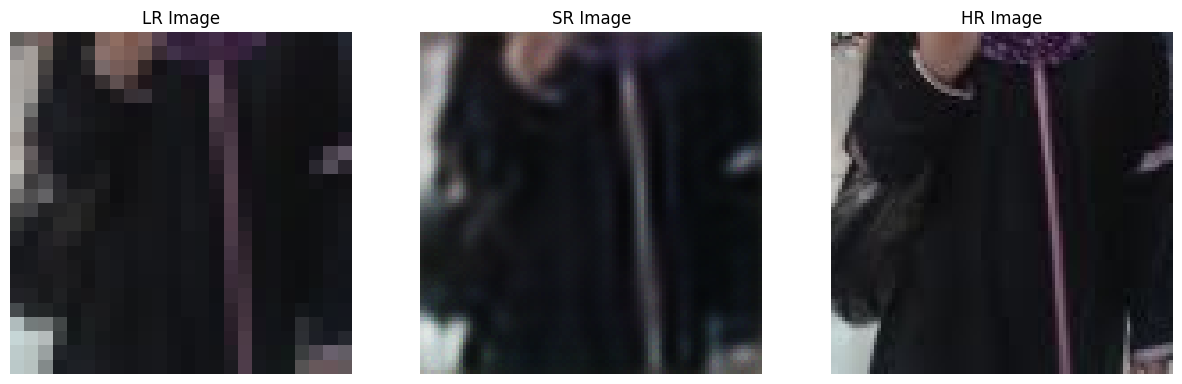

Epoch 2/25, Train Loss: 0.0248, Val Loss: 0.0265


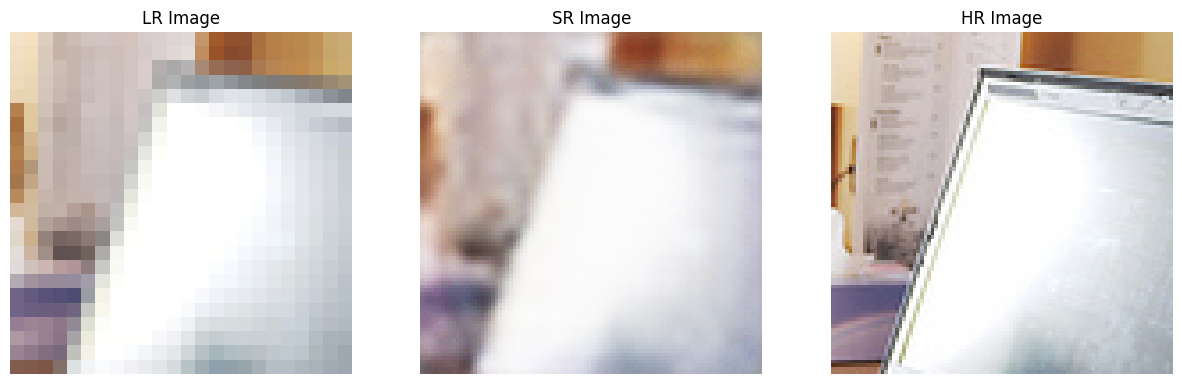

Epoch 3/25, Train Loss: 0.0227, Val Loss: 0.0254


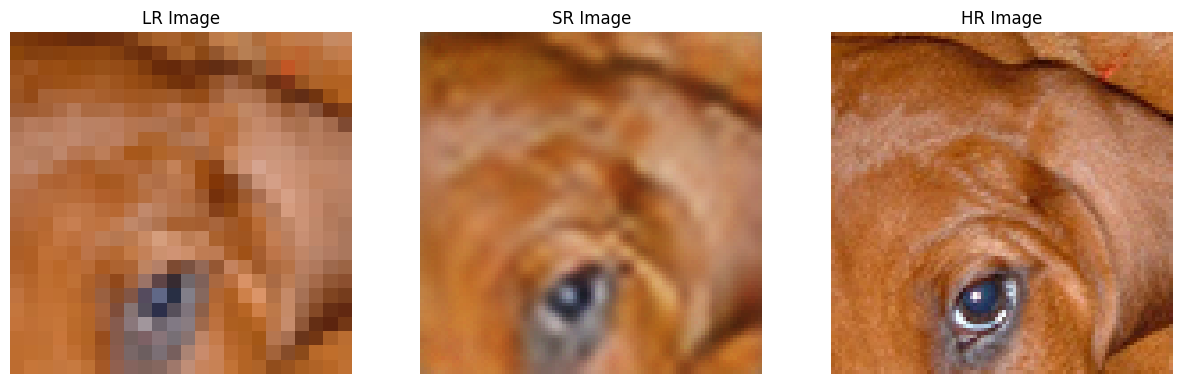

Epoch 4/25, Train Loss: 0.0216, Val Loss: 0.0249


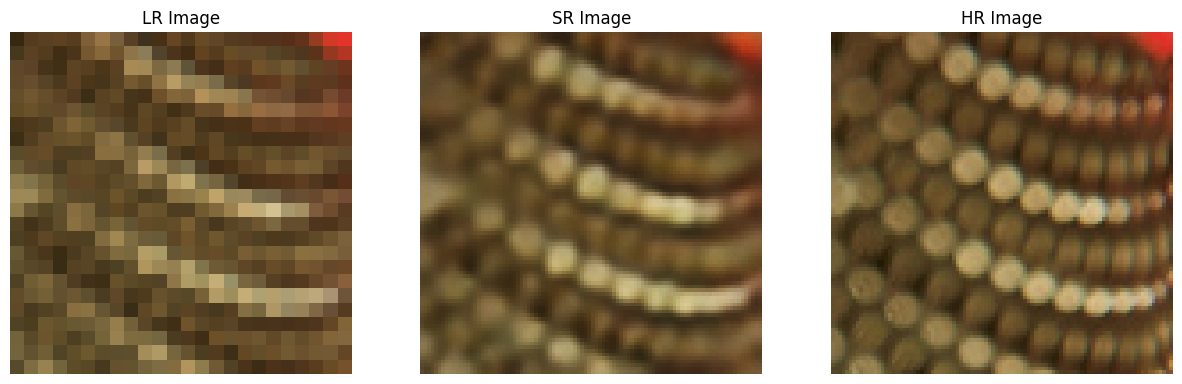

Epoch 5/25, Train Loss: 0.0209, Val Loss: 0.0239


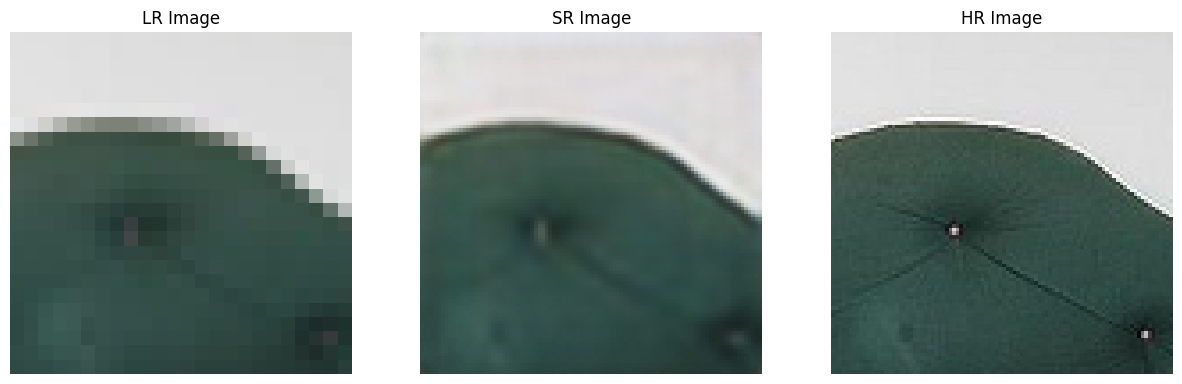

Epoch 6/25, Train Loss: 0.0205, Val Loss: 0.0235


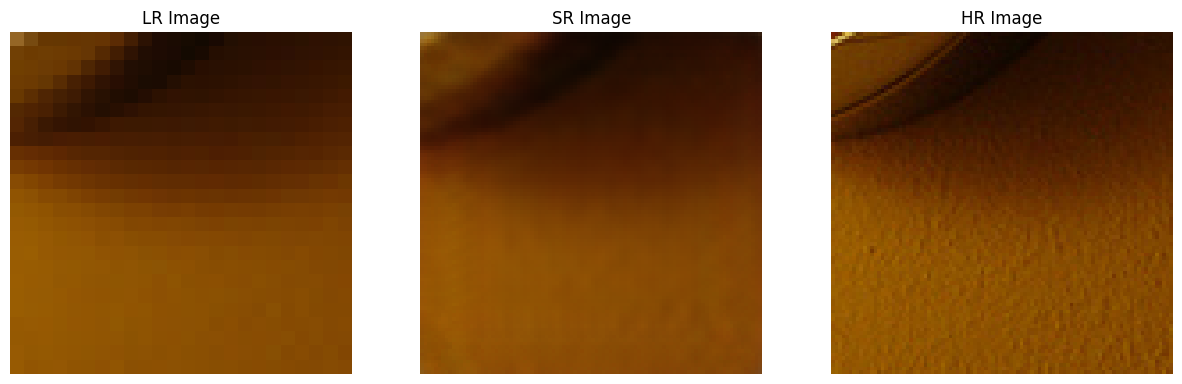

Epoch 7/25, Train Loss: 0.0202, Val Loss: 0.0231


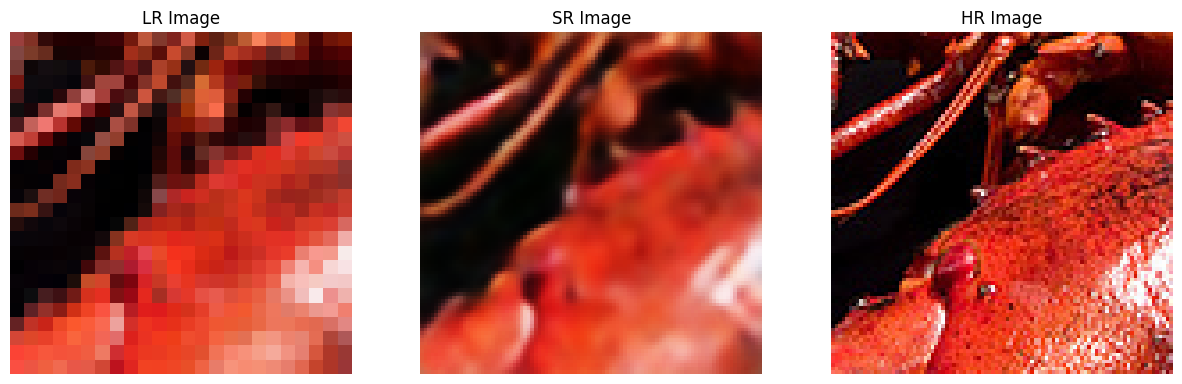

Epoch 8/25, Train Loss: 0.0197, Val Loss: 0.0228


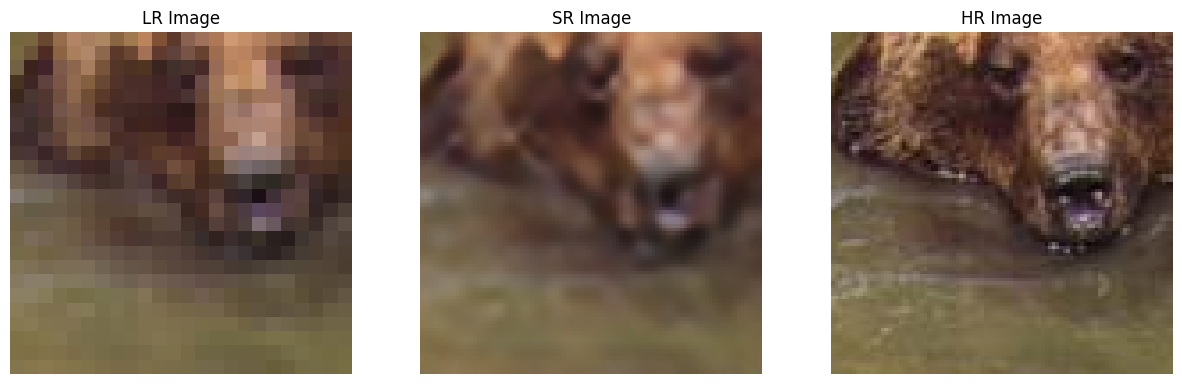

Epoch 9/25, Train Loss: 0.0196, Val Loss: 0.0228


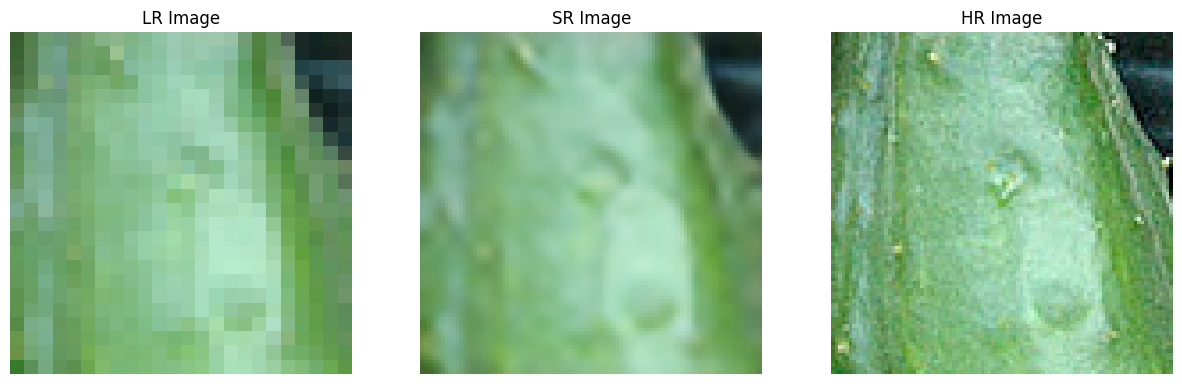

Epoch 10/25, Train Loss: 0.0194, Val Loss: 0.0225


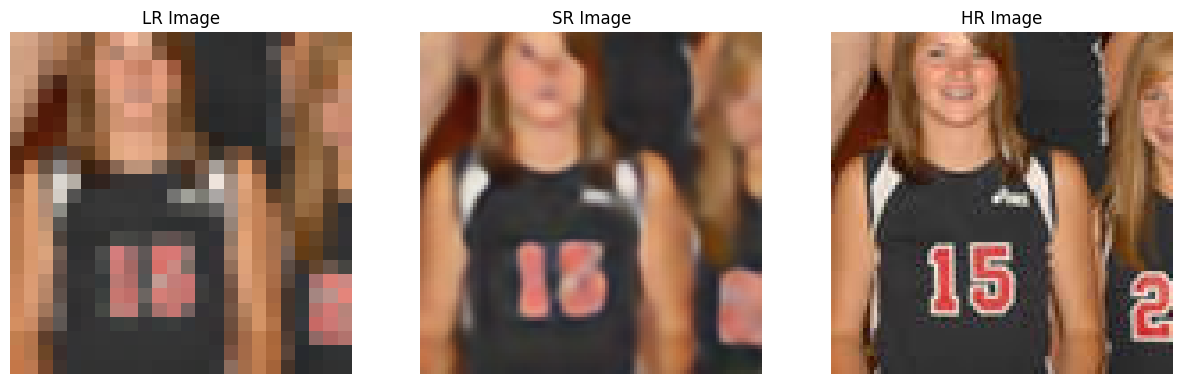

Epoch 11/25, Train Loss: 0.0192, Val Loss: 0.0223


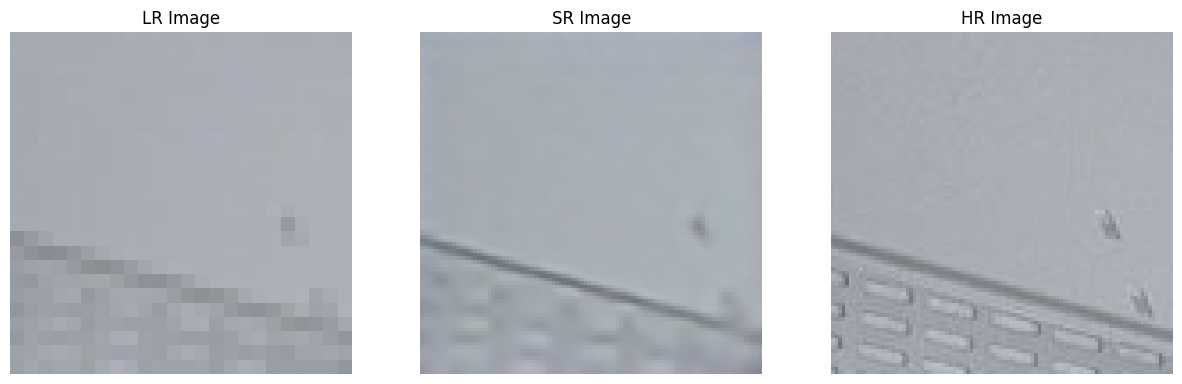

Epoch 12/25, Train Loss: 0.0190, Val Loss: 0.0223


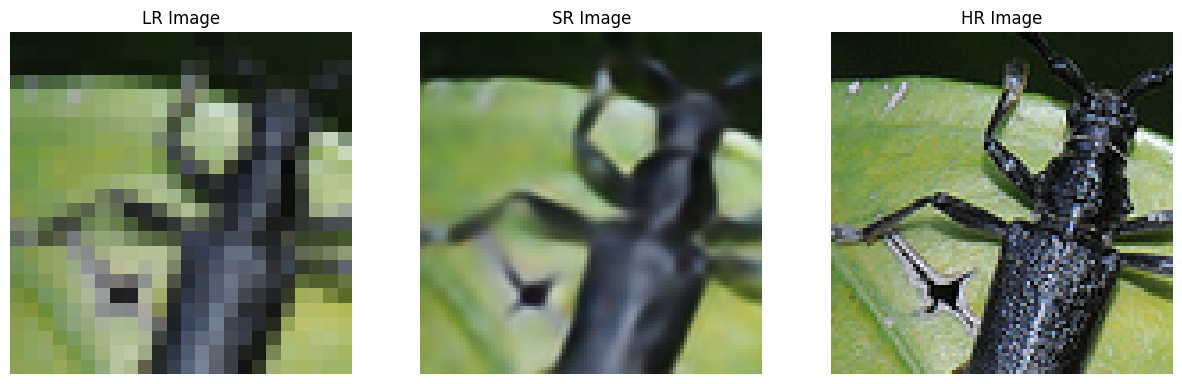

Epoch 13/25, Train Loss: 0.0189, Val Loss: 0.0220


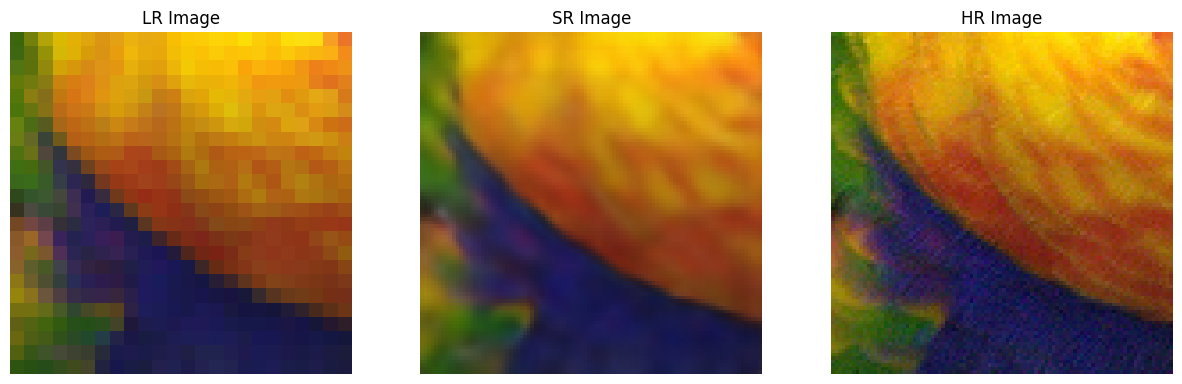

Epoch 14/25, Train Loss: 0.0189, Val Loss: 0.0220


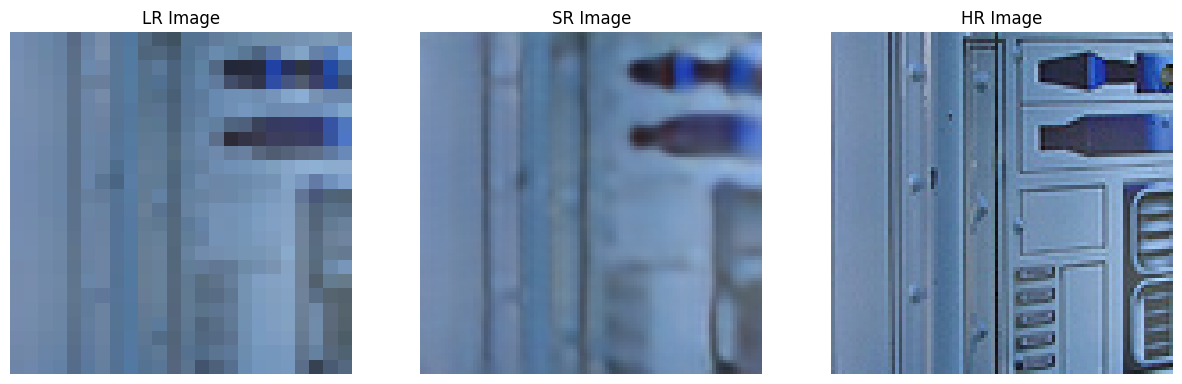

Epoch 15/25, Train Loss: 0.0188, Val Loss: 0.0218


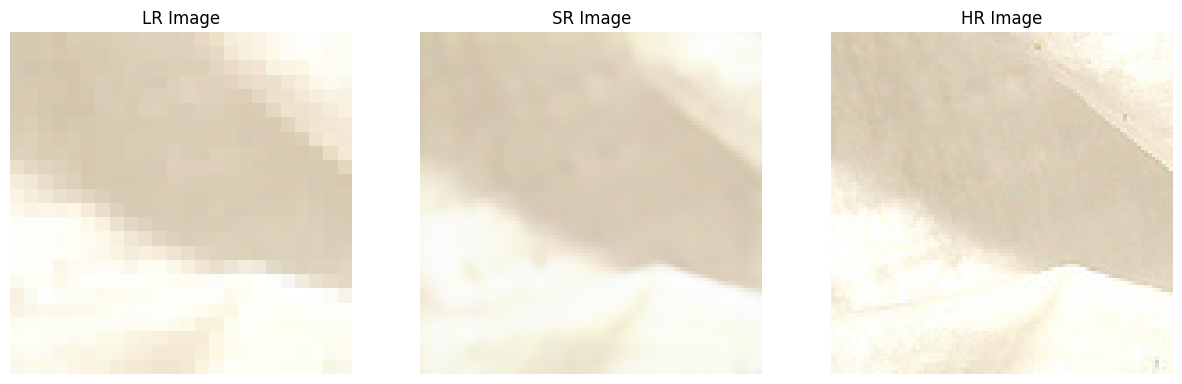

Epoch 16/25, Train Loss: 0.0187, Val Loss: 0.0219


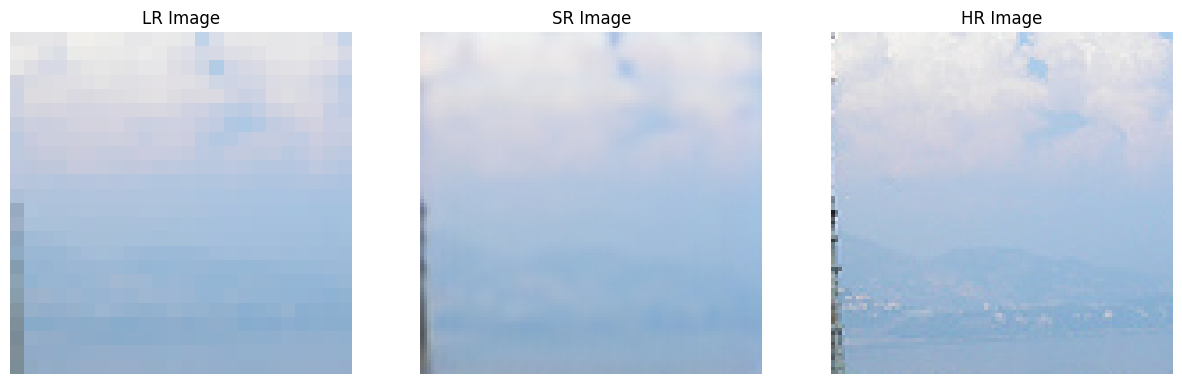

Epoch 17/25, Train Loss: 0.0188, Val Loss: 0.0217


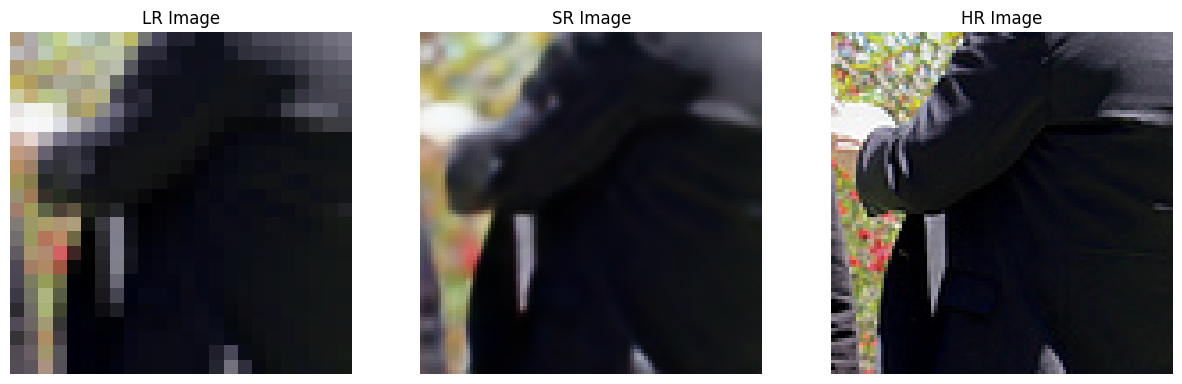

Epoch 18/25, Train Loss: 0.0186, Val Loss: 0.0216


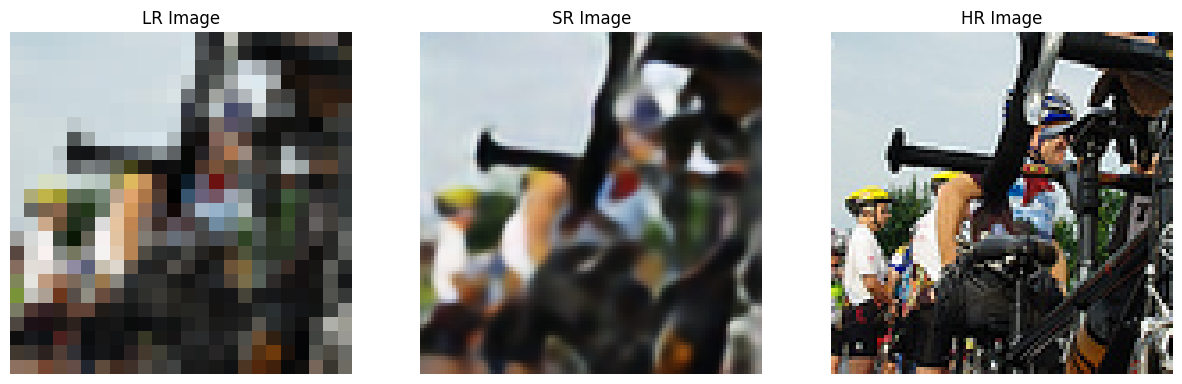

Epoch 19/25, Train Loss: 0.0185, Val Loss: 0.0216


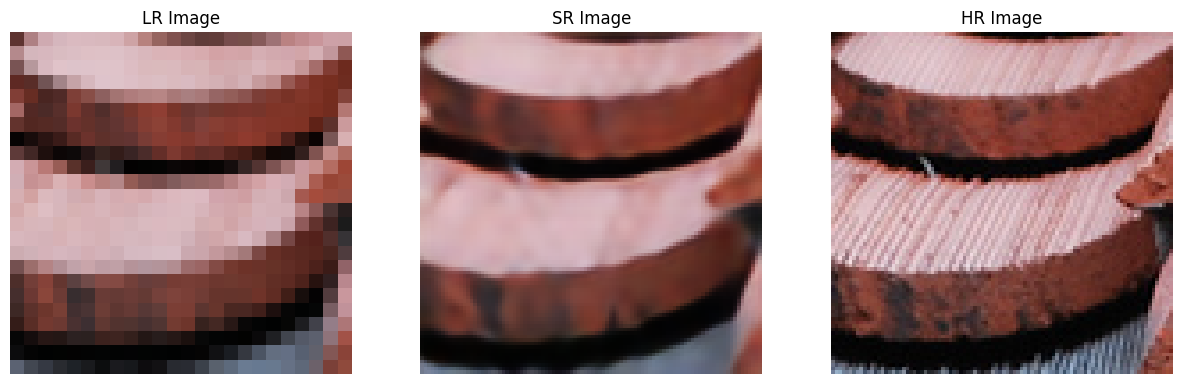

Epoch 20/25, Train Loss: 0.0184, Val Loss: 0.0215


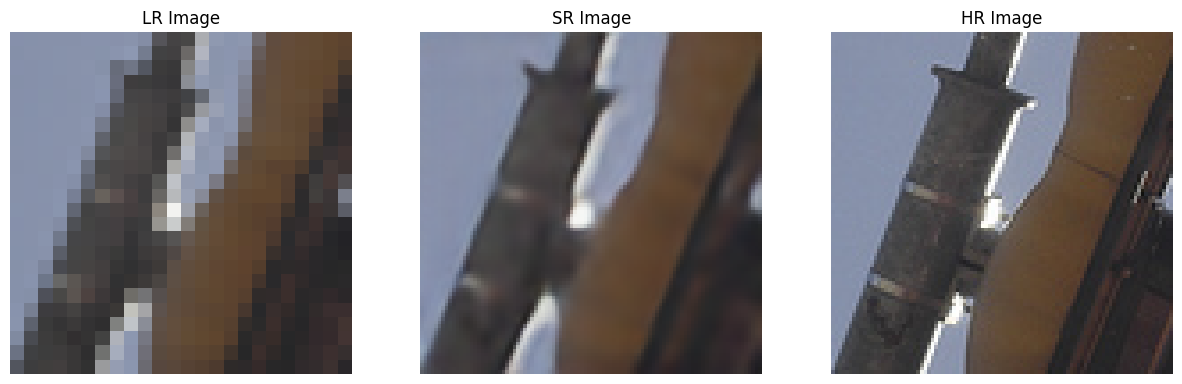

Epoch 21/25, Train Loss: 0.0183, Val Loss: 0.0215


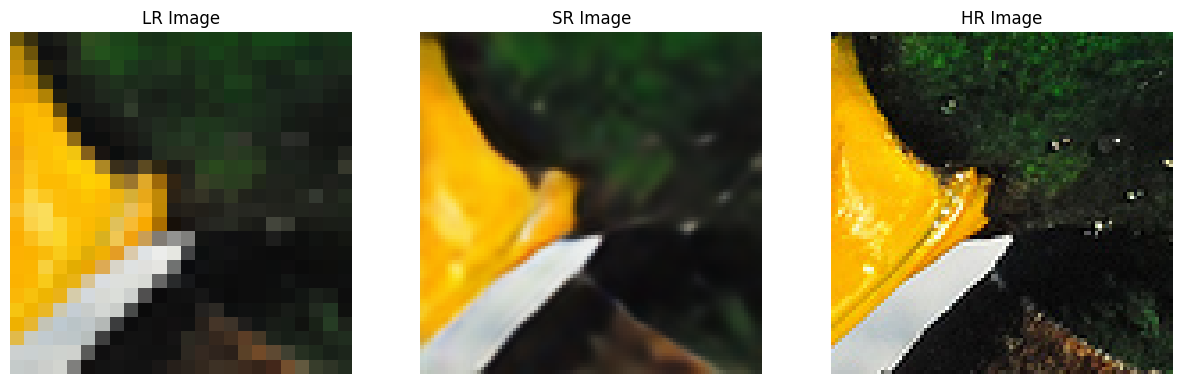

Epoch 22/25, Train Loss: 0.0184, Val Loss: 0.0214


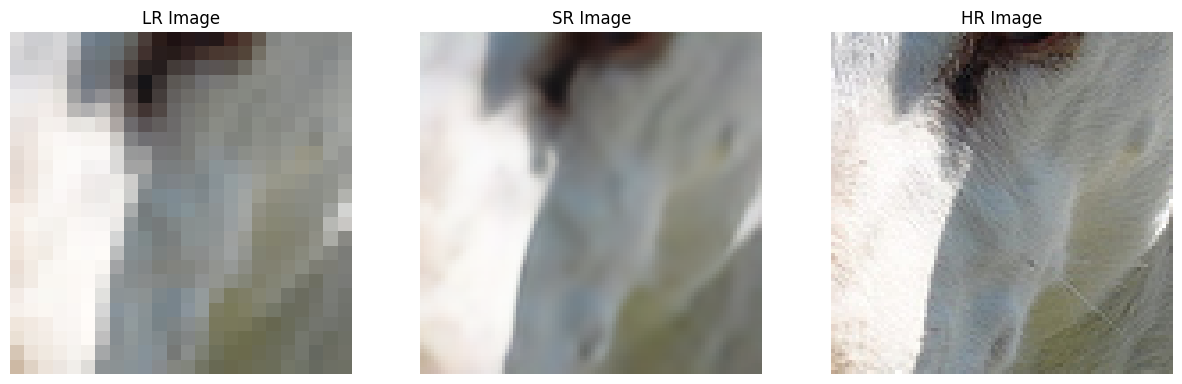

Epoch 23/25, Train Loss: 0.0182, Val Loss: 0.0214


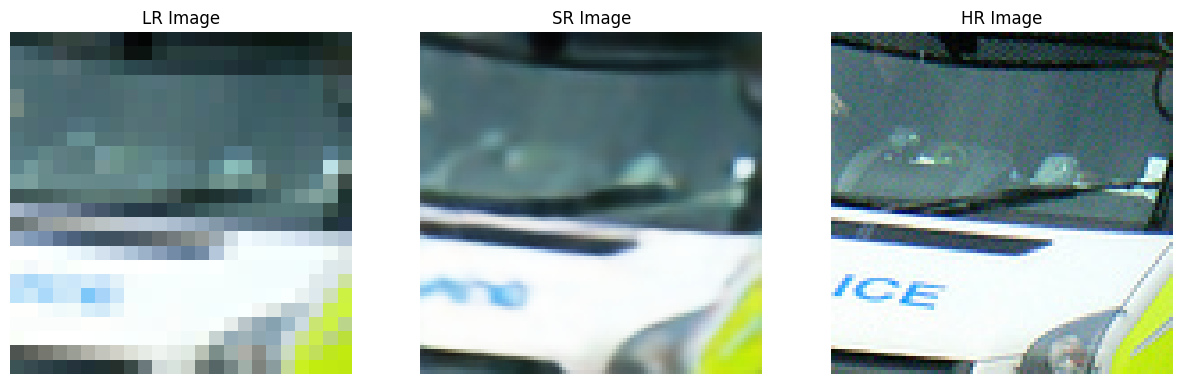

Epoch 24/25, Train Loss: 0.0183, Val Loss: 0.0214


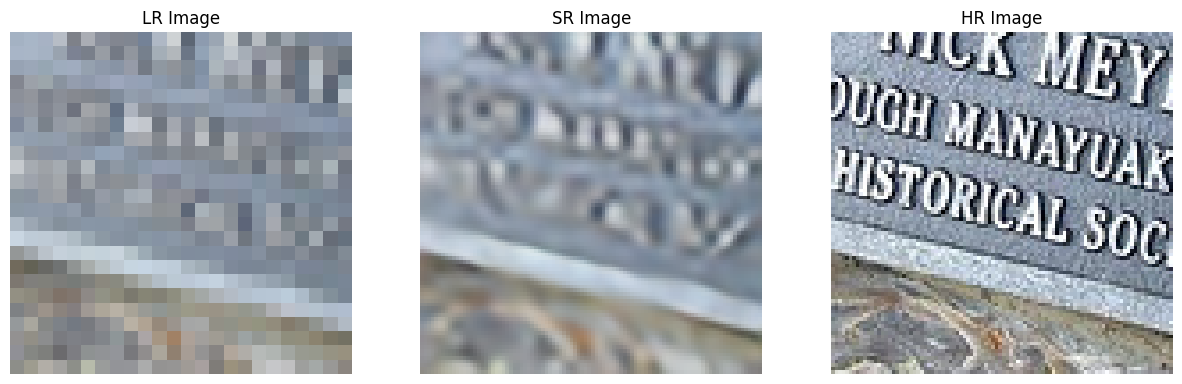

Epoch 25/25, Train Loss: 0.0180, Val Loss: 0.0213


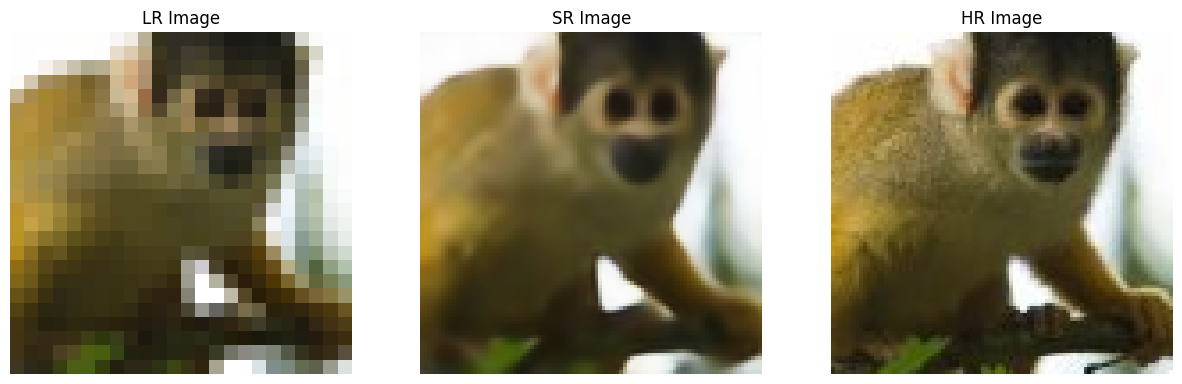

In [10]:
epochs = 25
for epoch in range(epochs):
    train_loss = train_model(model, train_loader, criterion, optimizer, device)
    val_loss = validate_model(model, val_loader, criterion, device)
    scheduler.step()
    print(f"Epoch {epoch + 1}/{epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

    model.eval()
    with torch.no_grad():
        lr_sample, hr_sample = next(iter(val_loader))
        
        lr_sample = lr_sample.to(device)
        hr_sample = hr_sample.to(device)
        
        sr_sample = model(lr_sample)
        
        lr_img = lr_sample[0].cpu().numpy().transpose(1, 2, 0)
        sr_img = sr_sample[0].cpu().numpy().transpose(1, 2, 0)
        hr_img = hr_sample[0].cpu().numpy().transpose(1, 2, 0)
        
        fig, axs = plt.subplots(1, 3, figsize=(15, 5))
        
        axs[0].imshow(lr_img.clip(0,1))
        axs[0].set_title("LR Image")
        axs[0].axis('off')
        
        axs[1].imshow(((sr_img.clip(-1,1)) + 1) / 2.0)
        axs[1].set_title("SR Image")
        axs[1].axis('off')
        
        axs[2].imshow(((hr_img.clip(-1,1)) + 1) / 2.0)
        axs[2].set_title("HR Image")
        axs[2].axis('off')
        
        plt.show()

In [11]:
torch.save(model.state_dict(), 'SRResNet.pth')